In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_test = pd.read_csv('Dataset\\Test\\test_data.csv')
X_test = data_test.iloc[:, :49].values
y_test = data_test.iloc[:, -1].values
X_test = X_test.reshape((X_test.shape[0], 7, 7, 1))

In [3]:
with open('Models\\GlobalModel\\Global_Model.pkl', 'rb') as f:
        saved_models = pickle.load(f)
    
stacker_lstm_model = saved_models['stacker_lstm_model']
stacker_cnn_model = saved_models['stacker_cnn_model']
combined_model = saved_models['combined_model']
submodels = saved_models['base_models']

In [4]:
print("Submodel Predictions")
base_model_test_predictions = [model.predict([X_test,X_test,X_test,X_test,X_test]) for model in submodels]
meta_model_input = np.concatenate(base_model_test_predictions, axis=-1)
print("Stacker LSTM Model Predictions")
stacker_lstm_model_predictions = stacker_lstm_model.predict(meta_model_input)
print("Stacker CNN Model Predictions")
stacker_cnn_model_predictions = stacker_cnn_model.predict(meta_model_input)
print("Combined Model Predictions")
combined_model_list = np.concatenate([stacker_lstm_model_predictions,stacker_cnn_model_predictions], axis=1)
combined_model_list = np.reshape(combined_model_list, (combined_model_list.shape[0], 1, combined_model_list.shape[1]))    
combined_model_predictions = combined_model.predict(combined_model_list)

Submodel Predictions
1407/1407 [==============================] - 15s 10ms/step
Stacker LSTM Model Predictions
1407/1407 [==============================] - 3s 2ms/step
Stacker CNN Model Predictions
1407/1407 [==============================] - 3s 2ms/step
Combined Model Predictions
1407/1407 [==============================] - 3s 2ms/step


In [12]:
y_pred_labels = np.argsort(-combined_model_predictions, axis=1)[:, :2]
Test_accuracy = np.mean([1 if y_test[i] in y_pred_labels[i] else 0 for i in range(len(y_test))])

In [13]:
print(f"The Accuracy is {round(Test_accuracy*100,2)}%")

The Accuracy is 92.74%


In [14]:
class_correct = {cls: 0 for cls in np.unique(y_test)}
class_total = {cls: 0 for cls in np.unique(y_test)}
for i in range(len(y_test)):
    predicted_classes = y_pred_labels[i]
    if y_test[i] in predicted_classes:
        class_correct[y_test[i]] += 1
    class_total[y_test[i]] += 1
class_accuracy = {cls: class_correct[cls] / class_total[cls] for cls in class_correct}
for cls, accuracy in class_accuracy.items():
    print(f"Accuracy for class {cls}: {accuracy:.2f}")

Accuracy for class 0: 1.00
Accuracy for class 1: 0.94
Accuracy for class 2: 0.86
Accuracy for class 3: 0.36
Accuracy for class 4: 0.90
Accuracy for class 5: 0.98
Accuracy for class 6: 0.77
Accuracy for class 7: 0.86
Accuracy for class 8: 0.93
Accuracy for class 9: 0.69
Accuracy for class 10: 0.92
Accuracy for class 11: 0.69
Accuracy for class 12: 0.97
Accuracy for class 13: 1.00
Accuracy for class 14: 0.97
Accuracy for class 15: 0.97
Accuracy for class 16: 0.90
Accuracy for class 17: 1.00


In [15]:
def predict_class(X_test):
    print("Submodel Predictions")
    # Generate predictions from each sub model on the test set
    base_model_test_predictions = [model.predict([X_test,X_test,X_test,X_test,X_test]) for model in submodels]
    meta_model_input = np.concatenate(base_model_test_predictions, axis=-1)
    print("Stacker LSTM Model Predictions")
    # Generate predictions from each Stacking LSTM model on the test set
    stacker_lstm_model_predictions = stacker_lstm_model.predict(meta_model_input)
    print("Stacker CNN Model Predictions")
    # Generate predictions from each stacking CNN model on the test set
    stacker_cnn_model_predictions = stacker_cnn_model.predict(meta_model_input)
    print("Combined Model Predictions")
    #Generate predictions from each Combined model on the test set
    combined_model_list = np.concatenate([stacker_lstm_model_predictions,stacker_cnn_model_predictions], axis=1)
    combined_model_list = np.reshape(combined_model_list, (combined_model_list.shape[0], 1, combined_model_list.shape[1]))    
    combined_model_predictions = combined_model.predict(combined_model_list)
    return combined_model_predictions

In [16]:
predictions = predict_class(X_test[0:5])

Submodel Predictions
1/1 [==============================] - 0s 34ms/step
Stacker LSTM Model Predictions
1/1 [==============================] - 0s 28ms/step
Stacker CNN Model Predictions
1/1 [==============================] - 0s 31ms/step
Combined Model Predictions
1/1 [==============================] - 0s 31ms/step


In [17]:
label_map = {
    0: "BENIGN",
    1: "DrDoS_DNS",
    2: "DrDoS_LDAP",
    3: "DrDoS_MSSQL",
    4: "DrDoS_NTP",
    5: "DrDoS_NetBIOS",
    6: "DrDoS_SNMP",
    7: "DrDoS_UDP",
    8: "LDAP",
    9: "MSSQL",
    10: "NetBIOS",
    11: "Portmap",
    12: "Syn",
    13: "TFTP",
    14: "UDP",
    15: "UDP-lag",
    16: "UDPLag",
    17: "WebDDoS",
}

predict = np.argsort(-predictions, axis=1)[:, :2]
for i, indices_row in enumerate(predict):
    labels_row = [label_map[index] for index in indices_row]
    print(f"Row {i + 1}:")
    for j, label in enumerate(labels_row):
        print(f"  Class {j + 1}: {label}")

Row 1:
  Class 1: DrDoS_LDAP
  Class 2: DrDoS_UDP
Row 2:
  Class 1: Syn
  Class 2: DrDoS_SNMP
Row 3:
  Class 1: DrDoS_LDAP
  Class 2: DrDoS_MSSQL
Row 4:
  Class 1: Syn
  Class 2: Portmap
Row 5:
  Class 1: BENIGN
  Class 2: WebDDoS


In [18]:
top_5_rows = data_test.iloc[0:5]
top_5_rows[' Label'] = top_5_rows[' Label'].map(label_map)

In [19]:
display(top_5_rows)

,Destination Port,Fwd Packet Length Mean,Packet Length Mean,Fwd Packet Length Min,Min Packet Length,Avg Fwd Segment Size,Fwd Packet Length Max,Max Packet Length,Average Packet Size,Total Length of Fwd Packets,...,Packet Length Std,Protocol,Bwd Packet Length Mean,Bwd IAT Min,Packet Length Variance,Subflow Bwd Bytes,Init_Win_bytes_backward,CWE Flag Count,Avg Bwd Segment Size,Label
0,24942,1448.0,1448.0,1448.0,1448.0,1448.0,1448.0,1448.0,2172.0,2896.0,...,0.0,17,0.0,0.0,0.0,0,-1,0,0.0,DrDoS_LDAP
1,47032,229.0,229.0,229.0,229.0,229.0,229.0,229.0,343.5,458.0,...,0.0,17,0.0,0.0,0.0,0,-1,0,0.0,Syn
2,55635,1472.0,1472.0,1472.0,1472.0,1472.0,1472.0,1472.0,2208.0,2944.0,...,0.0,17,0.0,0.0,0.0,0,-1,0,0.0,DrDoS_MSSQL
3,45286,229.0,229.0,229.0,229.0,229.0,229.0,229.0,343.5,458.0,...,0.0,17,0.0,0.0,0.0,0,-1,0,0.0,Syn
4,56874,6.0,6.0,6.0,6.0,6.0,6.0,6.0,8.0,6.0,...,0.0,6,6.0,2.0,0.0,12,256,1,6.0,BENIGN


In [20]:
probabilities_and_labels = []
for i in range(len(predictions)):
    probabilities = predictions[i][predict[i]]
    total_prob = np.sum(probabilities)
    probabilities_percentage = [(prob / 1.00) * 100 for prob in probabilities]
    labels = [label_map[index] for index in predict[i]]
    # Append the probabilities and labels to the list
    probabilities_and_labels.append((probabilities_percentage, labels))

# Print the probabilities and corresponding labels
for i, (probs, labels) in enumerate(probabilities_and_labels):
    print(f"Sample {i+1}:")
    for j, label in enumerate(labels):
        print(f" {label}: {probs[j]:.2e} ({probs[j]:.2f}%)")

Sample 1:
 DrDoS_LDAP: 5.87e+01 (58.72%)
 DrDoS_UDP: 3.69e+01 (36.87%)
Sample 2:
 Syn: 4.97e+01 (49.66%)
 DrDoS_SNMP: 2.79e+01 (27.91%)
Sample 3:
 DrDoS_LDAP: 7.62e+01 (76.18%)
 DrDoS_MSSQL: 1.12e+01 (11.19%)
Sample 4:
 Syn: 6.69e+01 (66.91%)
 Portmap: 2.69e+01 (26.94%)
Sample 5:
 BENIGN: 9.98e+01 (99.82%)
 WebDDoS: 6.98e-02 (0.07%)


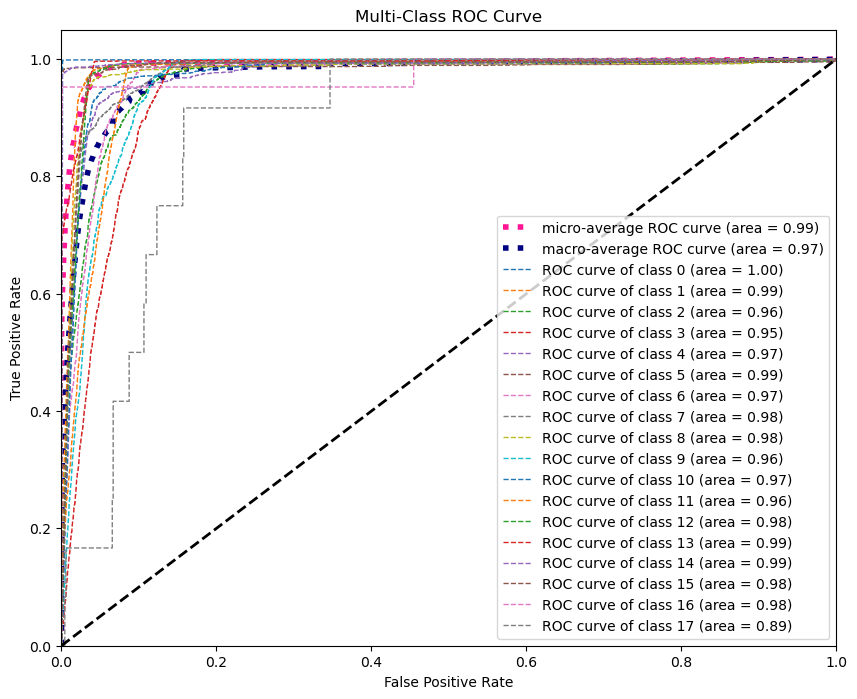

In [21]:
from sklearn.metrics import accuracy_score

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], combined_model_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), combined_model_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]), linestyle='--', linewidth=1)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.savefig('C:\\Users\\karth\\Documents\\Final Year Project\\Images\\multi_class_roc_curve.png')
plt.show()